In [1]:
# @title Necessary imports and globals.

import numpy as np
import os
import pandas as pd
from collections import defaultdict
from dopamine.agents.dqn import dqn_agent
from dopamine.discrete_domains import run_experiment
from dopamine.colab import utils as colab_utils
from absl import flags
import gin.tf

import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, Button
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

from tensorflow.python.summary.summary_iterator import summary_iterator

DQN_BASE_PATH = '../Simple_Domain_Results/offline_rl/DQN_results'
BASE_PATH = '../Simple_Domain_Results/offline_rl/DQN_reg_results'
replay_size = '100'
games = ['Acrobot'] 
runs = ['1', '2', '3']
GAME = 'Acrobot'

In [2]:
def load_dqn_data(experimental_data, summary_key='train_episode_returns'):
    # @title Load DQN + Adam results
    for env_index in range(len(games)):
        for RUN in runs:
            GAME = games[env_index]
            LOG_PATH = os.path.join(DQN_BASE_PATH, GAME, 'replay_size={}'.format(replay_size), RUN)
            reg_data = colab_utils.read_experiment(
                LOG_PATH, verbose=True, summary_keys=[summary_key])
            reg_data['agent'] = 'dqn+adam'
            reg_data['run_number'] = RUN
            if GAME not in experimental_data:
                experimental_data[GAME] = reg_data
            else:
                experimental_data[GAME] = pd.concat([experimental_data[GAME], reg_data])

def load_dqn_reg_data(experimental_data, summary_key='train_episode_returns', reg_weights=[0.01]):
    # @title Load the training logs.
    for GAME in games:
        for reg_weight in reg_weights:
            for K in ['32']:
                for noise_stddev in [0.0]:
                    for gradient_input in ['penultimate']:
                        for RUN in runs:
                            LOG_PATH = os.path.join(
                                BASE_PATH, 'reg_weight={}'.format(reg_weight), 'K={}'.format(K), 
                                'noise_stddev={}'.format(noise_stddev), 'gradient_input={}'.format(gradient_input), 
                                GAME, 'replay_size={}'.format(replay_size), RUN)
                            reg_data = colab_utils.read_experiment(
                                LOG_PATH, verbose=True, summary_keys=[summary_key])
                            reg_data['agent'] = 'dqn+adam-Reg: K={}, reg_weight={}, noise_stddev={}, grad_input={}'.format(
                                K, reg_weight, noise_stddev, gradient_input)
                            reg_data['run_number'] = RUN
                            if GAME not in experimental_data:
                                experimental_data[GAME] = reg_data
                            else:
                                experimental_data[GAME] = pd.concat([experimental_data[GAME], reg_data])

def get_huber_losses(path):
    steps = []
    huber_losses = []
    for entry in summary_iterator(path):
        try:
            step = entry.step
            v = entry.summary.value[0]
            tag, value = v.tag, v.simple_value
            if (tag == 'Losses/HuberLoss'):
                # print(step, tag, value)
                # print()
                steps.append(int(step))
                huber_losses.append(float(value))
        except Exception as e:
            pass
    
    return steps, huber_losses
                            
def load_td_error_data(reg_weight=0.01):
    dqn_td_error_data = defaultdict()
    dqn_reg_td_error_data = defaultdict()
    
    noise_stddev = 0.0
    K=32
    
    for GAME in games:
        dqn_prefix = '{}/{}/replay_size={}'.format(DQN_BASE_PATH, GAME, replay_size)
        dqn_reg_prefix = '{}/reg_weight={}/K={}/noise_stddev={}/gradient_input=penultimate/{}/replay_size={}'.format(
            BASE_PATH, reg_weight, K, noise_stddev, GAME, replay_size)
        
        for RUN in runs:
            dqn_file_path = '{}/{}'.format(dqn_prefix, RUN)
            dqn_reg_file_path = '{}/{}'.format(dqn_reg_prefix, RUN)
            
            dqn_files = os.listdir(dqn_file_path)
            dqn_reg_files = os.listdir(dqn_reg_file_path)
            for i in range(len(dqn_files)):
                if 'events' in dqn_files[i]:
                    dqn_file_path = '{}/{}'.format(dqn_file_path, dqn_files[i])
            for i in range(len(dqn_reg_files)):
                if 'events' in dqn_reg_files[i]:
                    dqn_reg_file_path = '{}/{}'.format(dqn_reg_file_path, dqn_reg_files[i])
            
            dqn_steps, dqn_huber_losses = get_huber_losses(dqn_file_path)
            dqn_reg_steps, dqn_reg_huber_losses = get_huber_losses(dqn_reg_file_path)
            
            dqn_td_error_data[RUN] = dqn_huber_losses
            dqn_reg_td_error_data[RUN] = dqn_reg_huber_losses
    
    return dqn_td_error_data, dqn_reg_td_error_data
        

In [3]:
experimental_train_data = defaultdict()
experimental_eval_data = defaultdict()

load_dqn_data(experimental_train_data, 'train_episode_returns')
load_dqn_reg_data(experimental_train_data, 'train_episode_returns', reg_weights=[0.01, 0.001, 0.0001])

# load_dqn_data(experimental_eval_data, 'eval_episode_returns')
# load_dqn_reg_data(experimental_eval_data, 'eval_episode_returns')

Reading statistics from: ../Simple_Domain_Results/offline_rl/DQN_results/Acrobot/replay_size=100/1//logs/log_99
Reading statistics from: ../Simple_Domain_Results/offline_rl/DQN_results/Acrobot/replay_size=100/2//logs/log_99
Reading statistics from: ../Simple_Domain_Results/offline_rl/DQN_results/Acrobot/replay_size=100/3//logs/log_99
Reading statistics from: ../Simple_Domain_Results/offline_rl/DQN_reg_results/reg_weight=0.01/K=32/noise_stddev=0.0/gradient_input=penultimate/Acrobot/replay_size=100/1//logs/log_99
Reading statistics from: ../Simple_Domain_Results/offline_rl/DQN_reg_results/reg_weight=0.01/K=32/noise_stddev=0.0/gradient_input=penultimate/Acrobot/replay_size=100/2//logs/log_99
Reading statistics from: ../Simple_Domain_Results/offline_rl/DQN_reg_results/reg_weight=0.01/K=32/noise_stddev=0.0/gradient_input=penultimate/Acrobot/replay_size=100/3//logs/log_99
Reading statistics from: ../Simple_Domain_Results/offline_rl/DQN_reg_results/reg_weight=0.001/K=32/noise_stddev=0.0/gradi

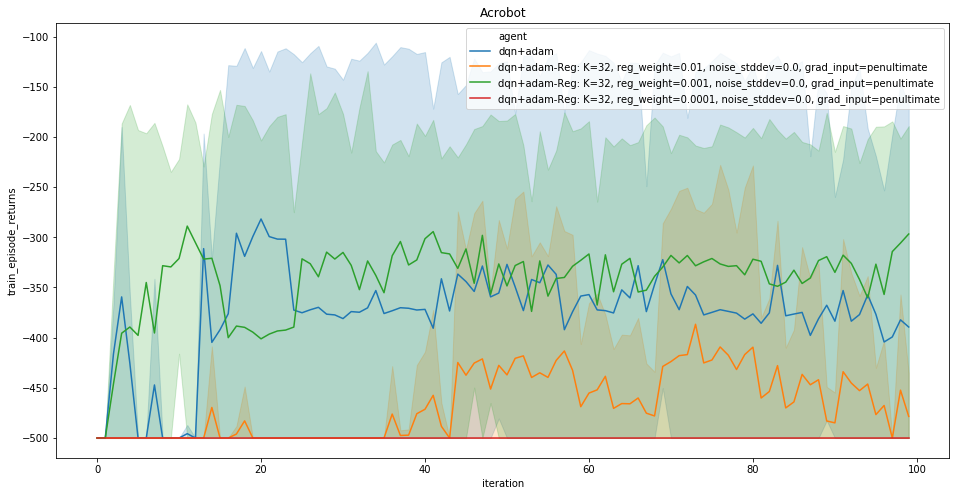

In [4]:
# @title Plot training results.

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(16,8))
sns.lineplot(
    x='iteration', y='train_episode_returns', hue='agent',
    data=experimental_train_data[GAME], ax=ax)
plt.title(GAME)
plt.show()

In [5]:
# @title Plot eval results.

# import seaborn as sns
# import matplotlib.pyplot as plt
# %matplotlib inline

# fig, ax = plt.subplots(figsize=(16,8))
# sns.lineplot(
#     x='iteration', y='eval_episode_returns', hue='agent',
#     data=experimental_eval_data[GAME], ax=ax)
# plt.title(GAME)
# plt.show()

In [6]:
dqn_td_error_data, dqn_reg_td_error_data = load_td_error_data()

Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


Reading statistics from: ../Simple_Domain_Results/offline_rl/DQN_results/Acrobot/replay_size=100/1//logs/log_99
Reading statistics from: ../Simple_Domain_Results/offline_rl/DQN_results/Acrobot/replay_size=100/2//logs/log_99
Reading statistics from: ../Simple_Domain_Results/offline_rl/DQN_results/Acrobot/replay_size=100/3//logs/log_99
Reading statistics from: ../Simple_Domain_Results/offline_rl/DQN_results/Acrobot/replay_size=100/1//logs/log_99
Reading statistics from: ../Simple_Domain_Results/offline_rl/DQN_results/Acrobot/replay_size=100/2//logs/log_99
Reading statistics from: ../Simple_Domain_Results/offline_rl/DQN_results/Acrobot/replay_size=100/3//logs/log_99


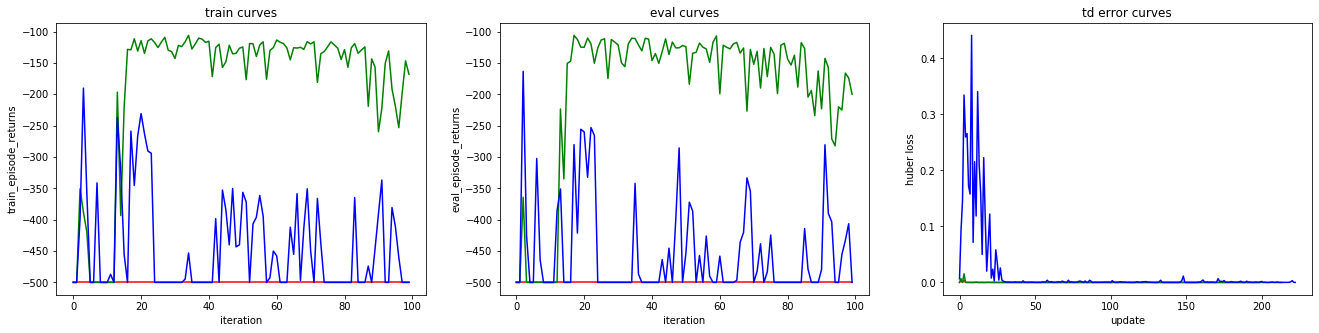

In [9]:
# The parametrized function to be plotted

experimental_train_data = defaultdict()
experimental_eval_data = defaultdict()

load_dqn_data(experimental_train_data, 'train_episode_returns')
load_dqn_data(experimental_eval_data, 'eval_episode_returns')

# load_dqn_reg_data(experimental_train_data, 'train_episode_returns', reg_weights=[0.0001])
# load_dqn_reg_data(experimental_eval_data, 'eval_episode_returns', reg_weights=[0.0001])

colors = ['red', 'g', 'b', 'orange', 'm']

fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_figheight(5)
fig.set_figwidth(22.5)

for i in range(3):
    RUN = i + 1
    
    RUN = int(RUN)

    train_data = experimental_train_data[GAME]
    train_data = train_data[train_data['run_number'] == str(RUN)]

    sns.lineplot(x='iteration', y='train_episode_returns',
                 data=train_data, ax=ax1, color=colors[i])
    ax1.set_title('train curves')
    
    eval_data = experimental_eval_data[GAME]
    eval_data = eval_data[eval_data['run_number'] == str(RUN)]
    sns.lineplot(x='iteration', y='eval_episode_returns',
                 data=eval_data, ax=ax2, color=colors[i])
    ax2.set_title('eval curves')
    
    data = dqn_td_error_data[str(RUN)]
    sns.lineplot(x=np.arange(len(data)), y=data, ax=ax3, color=colors[i])
    ax3.set_xlabel('update')
    ax3.set_ylabel('huber loss')
    ax3.set_title('td error curves')